# CNN/Convolusion  Classifier

#### Load libraries

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import tensorflow.keras.layers as Layers
import pandas as pd

#### Load datasets from tensorflow this is a dataset of handwritten integer images

In [36]:
# Load MNIST dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

#### Plot the images

The images are 2d so it doesn't have channels of red, green and blue. Its just grey-scaled, they are 28 pixels height x 28 pixels width.

In [37]:
print("Shape: (num_image_examples, num_pixel_height, num_pixel_width)")
print("Training images shape:", X_train.shape)
print("Training labels shape:", Y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", Y_test.shape)

Shape: (num_image_examples, num_pixel_height, num_pixel_width)
Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [38]:
image_shape = X_train[1].shape
image_shape

(28, 28)

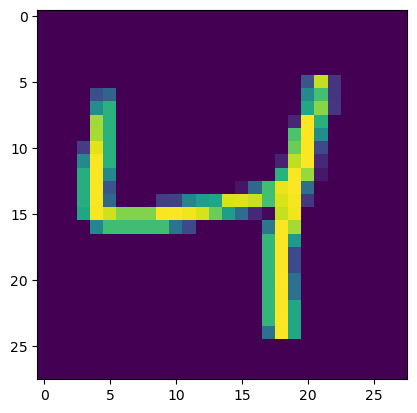

In [39]:
# plot images by index of the dataset
index = 2
plt.imshow(X_train[index]) #display sample training image
plt.show()

#### Preprocess the Data

In [40]:
# Normalize the images so that the model can converge faster
# Normalize pixel values to range [0, 1] means values are in range from 0 to 1 and 255 is the maximum value a pixel can be so we divide by it
train_images, test_images = X_train / 255.0, X_test / 255.0

In [41]:
Y_train # 5 means that the corresponding image is a handwritten 5 and so is 0 and 4, etc...

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [42]:
np.unique(Y_test) # get the unique number of classes this means that the handwritten int images
# are from 0 to 9

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
num_classes = len(np.unique(Y_test))
print(f"We have {num_classes} classes unique handwritten int images")

We have 10 classes unique handwritten int images


In [44]:
def convert_to_one_hot(Y, C):
    """
    Parameters
    ==========
    Y : np array
        is the array with ints that need to be converted to to one-hot
    C: int
        is the number of classes to identify, example we have handwritten images written that can range
        from 0-9 so we have 

    Converts a class of lets say [1] == a one handwritten image to 
    [1]
    [0]
    [0]     matrix so that the model will be able to see classes and classify it by that
    [0]
    [0]
    """
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

convert Y/labels to one-hot

In [45]:
Y_train = convert_to_one_hot(Y_train, num_classes).T
Y_test = convert_to_one_hot(Y_test, num_classes).T

In [46]:
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [47]:
X_train.shape, Y_train.shape

((60000, 28, 28), (60000, 10))

In [48]:
Y_train[0] # this index corresponds to the first 5 if u scroll up to the 
# print statement above Y_train = 5, 0, 4, ...
# the 1 is in the 5th index of the one-hot matrix starting from index 0

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [49]:
Y_train[1] # the 0 after the 5 has a 1 in the zero'th index

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Model

In [50]:
def CNN_Model(input_shape, num_classes):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Arguments:
    input_shape -- the dataset of the X_train shape

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    """
    Where padding='same'
        means that when we apply a convolution over the dataset, 
        after filtering the output shape will be the same shape as whatever was inputted just changing
        the channel to be the of the filters size, example we pass a 3d image of size (64x64x3)
        to the Conv2d with the same parameters as below, we get an output matrix of shape
        (64, 64, 8). the 8 represents the filter size of that conv2d
    filters:
        means how many filters of a conv are we doing
    kernel_size:
        is the size of a single filter, example we have a 2d image of shape (16x16) we have 10 filters
        with kernel_size size (3x3) this means we are applying a (3x3) matrix over the 16x16 image 10 times
        to get the convolution output matrix
    stride: how much to skip when applying the filters 
    MaxPool2D:
        get the max int from each region of the input matrix, basic to make computation faster, we scale
        down the number of parameters, in this case at P1 the output of the RElU would be of shape
        (None, 64, 64, 8) then after the MaxPool2d we get (None, 8, 8, 8) so basically 8x8 = 64 we are
        reducing the parameter count/ downsampling
    Flatten:
        takes am=n input matrix of like 2d, or 3d etc.. and flatten it to a one-dimensional array of
        shape (1, all the ints of the input matrix)
        input matrix (1, 2, 2, 16) flattens it to (1, 64) so from many nested arrays to one single array
        containing all the values

    Dense:
        a regular Neural Network not CNN that predicts the output using the soft max it will predict
        a array of one-hot encoding like when we encoded the Y/labels
        units should be same size as the number of classes in a one-hot encoding 

    Since we are using 2D images we use the Conv1D etc so 1D for all other layers, and we set the
    kernel_size, strides, and pool_size to an int instead of like a tuple (8, 8) for 3d images, 3d images
    means we have an image with 3 color channels
    """

    input_img = tf.keras.Input(shape=input_shape)
    
    Z1 = Layers.Conv1D(filters=8, kernel_size=4, strides=1, activation='linear', padding='same')(input_img)
    A1 = Layers.ReLU()(Z1)
    P1 = Layers.MaxPool1D(pool_size=8, strides=8, padding='same')(A1)
    Z2 = Layers.Conv1D(filters=16, kernel_size=2, strides=1, activation='linear', padding='same')(P1)
    A2 = Layers.ReLU()(Z2)
    P2 = Layers.MaxPool1D(pool_size=4, strides=4, padding='same')(A2)
    F = Layers.Flatten()(P2)
    outputs = Layers.Dense(units=num_classes, activation='softmax')(F)

    # create the model
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

Create and Compile the model

In [51]:
conv_model = CNN_Model( image_shape, num_classes)

conv_model.compile(optimizer='adam', # pass the optimizer for gradient descent
                loss='categorical_crossentropy', # the loss function to calculate between true values and predicted values
                metrics=['accuracy']) #which metrics we want to save
conv_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 28, 8)             904       
                                                                 
 re_lu_5 (ReLU)              (None, 28, 8)             0         
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 4, 8)              0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 4, 16)             272       
                                                                 
 re_lu_6 (ReLU)              (None, 4, 16)             0         
                                                           

### Train The Model

In [52]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
# history = conv_model.fit(train_dataset, epochs=50, validation_data=test_dataset)
# train over 50 epochs means the model sees the whole dataset 50 times
# batch_size = 32 means we have batches that have 32 examples of images
# we valid on the test set
h = conv_model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/10
   7/1875 [..............................] - ETA: 17s - loss: 112.7343 - accuracy: 0.0759 

2024-03-28 11:28:24.575326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1870/1875 [============================>.] - ETA: 0s - loss: 5.4496 - accuracy: 0.3747

2024-03-28 11:28:40.840499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 5.4392 - accuracy: 0.3751 - val_loss: 1.4521 - val_accuracy: 0.5335
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 1.1193 - accuracy: 0.6423 - val_loss: 0.7994 - val_accuracy: 0.7493
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.6546 - accuracy: 0.8021 - val_loss: 0.5098 - val_accuracy: 0.8438
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.4558 - accuracy: 0.8658 - val_loss: 0.3766 - val_accuracy: 0.8880
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3720 - accuracy: 0.8910 - val_loss: 0.3474 - val_accuracy: 0.8907
Epoch 6/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3263 - accuracy: 0.9033 - val_loss: 0.2918 - val_accuracy: 0.9130
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2946 - accuracy: 0.9105 - val_loss: 0.2827 - val_accura

### Plot Training Stats

As we can see from the stats below, this basic model performs really well with a >90% accuracy

In [53]:
h.history

{'loss': [5.439155101776123,
  1.1192586421966553,
  0.6545752882957458,
  0.45576778054237366,
  0.3719988465309143,
  0.3263300359249115,
  0.29458996653556824,
  0.2734672427177429,
  0.25678199529647827,
  0.24277137219905853],
 'accuracy': [0.3750666677951813,
  0.642300009727478,
  0.8020833134651184,
  0.8657833337783813,
  0.8910333514213562,
  0.9032999873161316,
  0.9104666709899902,
  0.9170833230018616,
  0.9222833514213562,
  0.9256166815757751],
 'val_loss': [1.452133059501648,
  0.7993616461753845,
  0.5098254680633545,
  0.3765830099582672,
  0.3474029004573822,
  0.29183170199394226,
  0.2826945185661316,
  0.2529127299785614,
  0.2600686848163605,
  0.22727680206298828],
 'val_accuracy': [0.5335000157356262,
  0.7493000030517578,
  0.8438000082969666,
  0.8880000114440918,
  0.8906999826431274,
  0.9129999876022339,
  0.9140999913215637,
  0.925599992275238,
  0.9221000075340271,
  0.9318000078201294]}

/var/folders/kg/7xftw3_12y10ppg5bv5lb26w0000gn/T/ipykernel_71348/1348083433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/kg/7xftw3_12y10ppg5bv5lb26w0000gn/T/ipykernel_71348/1348083433.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

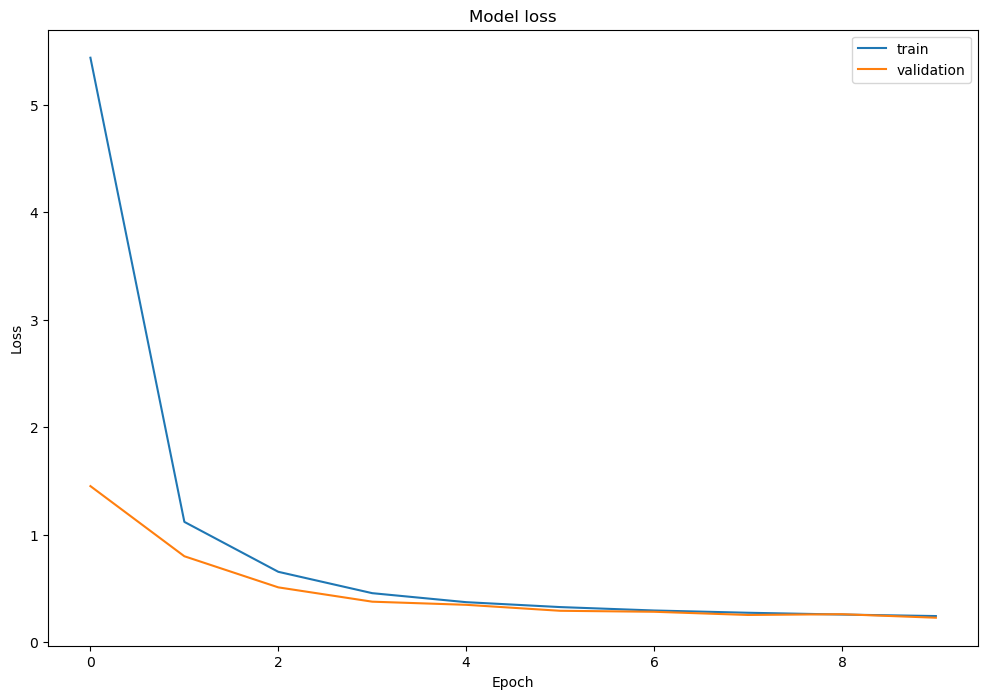

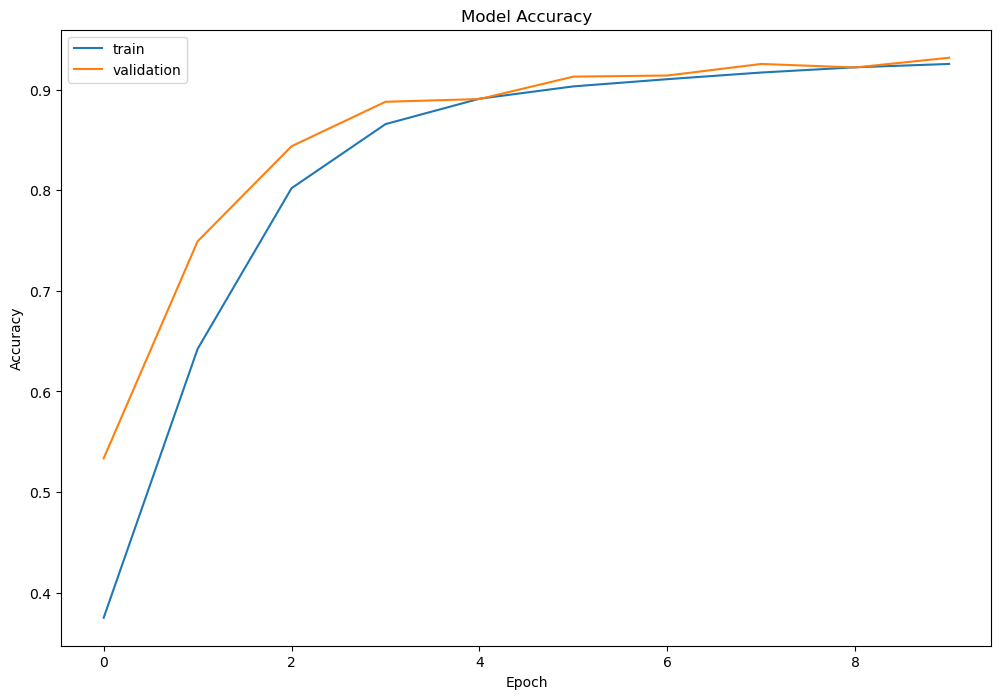

In [54]:
df_loss_acc = pd.DataFrame(h.history) # create dataframes of the data from training history
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')